# 0.0 Imorts

In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
from utils.data_preprocessing import ChangeDtypes, DataTreatment, FeatureEngineering

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

In [6]:
df = pd.read_csv('../data/df_raw.csv')

# 1.0 Preprocessing

In [7]:
df_train, df_val = train_test_split(df, test_size=0.30, stratify=df[['treatment_flg', 'target']], random_state=42)

In [8]:
X = df_train.drop(columns=['treatment_flg', 'target'])
y = df_train['treatment_flg']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [10]:
X_val = df_val.drop(columns=['treatment_flg', 'target'])
y_val = df_val['treatment_flg']

In [11]:
pipeline = Pipeline([('change d types', ChangeDtypes()),
                     ('tratamento', DataTreatment()),
                     ('feature engineering', FeatureEngineering())])

In [12]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
X_val = pipeline.transform(X_val)

In [13]:
columns_robust = ['n_transactions', 'mean_product_quantity', 'n_stores',
       'n_products', 'regular_points_received', 'express_points_received',
       'regular_points_spent', 'express_points_spent', 'total_amount_spent', 'avg_ticket']
columns_standard = ['age', 'recency', 'issue_redeem_delay' ]
categorical = ['gender']

In [14]:
rs = RobustScaler()
X_train[columns_robust] = rs.fit_transform(X_train[columns_robust])
X_test[columns_robust] = rs.transform(X_test[columns_robust])
X_val[columns_robust] = rs.transform(X_val[columns_robust])

In [15]:
ss = StandardScaler()
X_train[columns_standard] = ss.fit_transform(X_train[columns_standard])
X_test[columns_standard] = ss.transform(X_test[columns_standard])
X_val[columns_standard] = ss.transform(X_val[columns_standard])

In [16]:
ohe = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train['gender'].to_numpy().reshape(-1, 1)), columns=ohe.get_feature_names(), index=X_train.index)
X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_train= X_train.drop(columns=['gender'])
X_test_ohe = pd.DataFrame(ohe.transform(X_test['gender'].to_numpy().reshape(-1, 1)), columns=ohe.get_feature_names(), index=X_test.index)
X_test = pd.concat([X_test, X_test_ohe], axis=1)
X_test= X_test.drop(columns=['gender'])
X_val_ohe = pd.DataFrame(ohe.transform(X_val['gender'].to_numpy().reshape(-1, 1)), columns=ohe.get_feature_names(), index=X_val.index)
X_val = pd.concat([X_val, X_val_ohe], axis=1)
X_val= X_val.drop(columns=['gender'])

In [17]:
X_train.head()

,age,n_transactions,mean_product_quantity,n_stores,n_products,regular_points_received,express_points_received,regular_points_spent,express_points_spent,total_amount_spent,recency,avg_ticket,issue_redeem_delay,x0_M,x0_U
150926,0.544245,0.263158,-1.047893,0.000000,0.227273,-0.311902,0.0,-0.020408,-30.0,-0.145620,-1.027417,-0.416393,-0.893236,0.0,1.0
99056,0.922795,1.631579,-1.167136,0.666667,-0.075758,-0.009576,0.0,0.275510,0.0,0.316901,-0.850204,-0.589813,-0.000593,0.0,1.0
80781,0.922795,-0.315789,-0.324116,0.333333,-0.439394,-0.062927,0.0,0.275510,0.0,-0.383196,0.921933,-0.147669,-0.277882,0.0,0.0
124129,-1.285415,-0.157895,0.802638,1.333333,0.575758,0.347469,0.0,0.275510,0.0,0.257492,-0.495776,0.825905,0.713522,0.0,0.0
32148,-0.528314,-0.210526,0.200846,1.000000,-0.439394,-0.346101,0.0,0.275510,0.0,-0.351346,0.567506,-0.260053,-0.509589,0.0,0.0


# 2.0 Propensity of treatment modeling

Propensity of a individual receive a treatment given its covariates. If the treatment assignment is at random these scores should be concentrated around 0.5

In [18]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
accuracy_score(y_test, lr.predict(X_test))


0.5044871337094432

In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
accuracy_score(y_test, rf.predict(X_test))

0.4988454854912043

In [22]:
propensity_model = LogisticRegression(random_state=42)

propensity_model.fit(X_train, y_train)
p_train = propensity_model.predict_proba(X=X_train)
p_test = propensity_model.predict_proba(X=X_test)

p_train = pd.Series(p_train[:, 0], index=X_train.index)
p_test = pd.Series(p_test[:, 0], index=X_test.index)

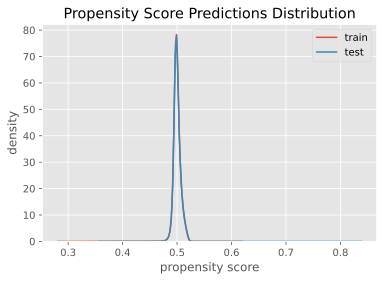

In [24]:
fig, ax = plt.subplots()
sns.kdeplot(x=p_train, label="train", ax=ax)
sns.kdeplot(x=p_test, label="test", ax=ax)
ax.legend()
ax.set(
    title="Propensity Score Predictions Distribution",
    xlabel="propensity score",
    ylabel="density",
)
plt.show()